# 02.21.03 - DNN MFCC20 (4-Fold, upsampled minority, data augmented) SOFTMAX

## Prerequisites

- The dataset exists (if not, execute 02.00)
- The dataset features have been populated (if not, execute 02.01)


## Goals

In this experiment, we intend to assess the generalization capability of a Dense Neural Network using MFCC coeffecicients as features, through a 4-folds cross validation over the hive axis.

In hope to improve generalization performance, we introduce data augmentation in the feature space, by adding samples  where feature rows are "scratched", i.e overwritten either with a fixed value (usually 0) or the mean of the feature cells (here we use the mean).

Our MFCC feature having 20 coefficients, this results in a dataset size 21 times as big as the intial one (original samples + scratched ones along each coefficient).

Additionnaly, to mitigate data unbalance, for each fold we randomly upsample the under-represented class in order to reach the same cardinality as the majority class.

*Note: In reality, due to the fact that some hives in the reference dataset only present one label value (either queen of noqueen) a fold may be an agregate of 2 distincts hives, but in any case, for each fold, the network is tested over samples belonging to hive(s) it was never trained on.*

Distribution details (before upsampling or data augmentation) are provided below:

<table border="1" class="dataframe" align="left">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fold</th>
      <th>hive</th>
      <th>queen</th>
      <th>count(*)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>CF001</td>
      <td>0.0</td>
      <td>14</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>CF003</td>
      <td>1.0</td>
      <td>3649</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>CJ001</td>
      <td>0.0</td>
      <td>790</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2</td>
      <td>GH001</td>
      <td>1.0</td>
      <td>1396</td>
    </tr>
    <tr>
      <th>4</th>
      <td>3</td>
      <td>Hive1</td>
      <td>0.0</td>
      <td>1473</td>
    </tr>
    <tr>
      <th>5</th>
      <td>3</td>
      <td>Hive1</td>
      <td>1.0</td>
      <td>2684</td>
    </tr>
    <tr>
      <th>6</th>
      <td>4</td>
      <td>Hive3</td>
      <td>0.0</td>
      <td>6545</td>
    </tr>
    <tr>
      <th>7</th>
      <td>4</td>
      <td>Hive3</td>
      <td>1.0</td>
      <td>654</td>
    </tr>
  </tbody>
</table>
<br><br><br><br><br><br><br><br><br><br><br><br><br>


## Conclusions

TODO (DID NOT RUN)


<hr style="border:1px solid gray"></hr>

### Step 1: Get previously created dataset

In [1]:
import warnings                      # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')    # commented out till the experiment final version,
                                     # in order to avoid missing "real" warnings 

import kilroy_was_here               # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import (
    iprint,                          # timestamped (to the ms) print with CPU and RAM consumption information  
    predestination,                  # Seeds various PRNGs for reproducibility
    say_my_name                      # gets notebook name
)

from audace.audiodataset import AudioDataset      # Main class for audio dataset handling

#########################
# Experiment parameters #
#########################

EXP_NAME = say_my_name()  # Experiment name will be used to create outputs directory

DATASET_NAME = 'MAIN1000' # Dataset name is the master key for dataset addressing
                          # Change it according to the dataset you want to process

FEATURE_NAME = 'mfcc20'   # Name of the feature used for classification
LABEL_NAME = 'queen'      # Name of the label used for classification
FOLD_NAME = 'fold'        # Column nam of the fold axis
VALID_FRAC = 0.3          # Fraction of the training set used for validation (NOT TESTING)
                          # This is used to drive early stopping. Hyperparameters may be tuned
                          # over the validation set, but the test set is kept isolated to avoid biases.


# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Build dataframe containing all the information needed to conduct the experiment
sql = F"SELECT {FEATURE_NAME}, {LABEL_NAME}, {FOLD_NAME} FROM samples WHERE nobee = 0"
df = ds.queryDataFrame(sql)

# Display cardinalities
sql = """
    select distinct fold, hive, queen, count(*)
    from samples
    where nobee = 0
    group by fold, queen
    order by fold, queen
    """
ds.queryDataFrame(sql)

[2020-09-09/19:34:29.724|27.1%|40.9%|0.28GB] ------------------------------------------------------
[2020-09-09/19:34:29.725|00.0%|40.9%|0.28GB] DATASET NAME          : MAIN1000
[2020-09-09/19:34:29.726|00.0%|40.9%|0.28GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-09-09/19:34:29.727|00.0%|40.9%|0.28GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-09-09/19:34:29.728|00.0%|40.9%|0.28GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-09-09/19:34:29.729|00.0%|40.9%|0.28GB] NB SOURCE AUDIO FILES : 48
[2020-09-09/19:34:29.729|00.0%|40.9%|0.28GB] SAMPLE RATE           : 22050
[2020-09-09/19:34:29.729|00.0%|40.9%|0.28GB] DURATION              : 1.0
[2020-09-09/19:34:29.729|00.0%|40.9%|0.28GB] OVERLAP               : 0.0
[2020-09-09/19:34:29.730|00.0%|40.9%|0.28GB] NB AUDIO CHUNKS       : 24788
[2020-09-09/19:34:29.730|00.0%|40.9%|0.28GB] ------------------------------------------------------


,fold,hive,queen,count(*)
0,1,CF001,0.0,14
1,1,CF003,1.0,3649
2,2,CJ001,0.0,790
3,2,GH001,1.0,1396
4,3,Hive1,0.0,1473
5,3,Hive1,1.0,2684
6,4,Hive3,0.0,6545
7,4,Hive3,1.0,654


<hr style="border:1px solid gray"></hr>

### Step 1bis: Augment dataset

<p style="color:red;"><b>Beware, due to quick and dirty implementation, this may take a loooong time (up to 45mn)</b></p>

In [2]:
from audace.augmenters import addScratchedFeatureRows

iprint("Dataset Length before data augmentation:", len(df.index))

# Expand dataset with data augmentation (uses mean by default)
df = addScratchedFeatureRows(df, FEATURE_NAME)

iprint("Dataset Length after augmentation:", len(df.index))

[2020-09-09/19:34:32.555|22.7%|43.0%|0.35GB] Dataset Length before data augmentation: 17205



[2020-09-09/20:29:02.435|34.3%|64.5%|0.13GB] Dataset Length after augmentation: 361305


<hr style="border:1px solid gray"></hr>

### Step 2: Process DNN learning

In [3]:
from tensorflow import keras

def nn(n_inputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=n_inputs))
    model.add(keras.layers.Dense(16, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(16, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(2, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy", optimizer="nadam",
        metrics=[
            "accuracy",
            "categorical_crossentropy"
        ]
    )    
    
    return model

In [5]:
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from audace.splitters import splitTrainValidTestFold
from audace.metrics import i_may_be_wrong_categorical

# Seed the various PRNGs
predestination()

histories = []
X_tests = []
y_tests = []
models = []

# Iterate over folds
for fold in ds.listAttributeValues(FOLD_NAME):
    print(F"############### FOLD {fold} ###############")
    # Build training and test datasets
    iprint(">>>>> Building partitions training/test")
    X_train, X_valid, X_test, y_train, y_valid, y_test = splitTrainValidTestFold(
        df,
        FEATURE_NAME,
        LABEL_NAME,
        FOLD_NAME,
        fold,
        VALID_FRAC,
        balance_strategy=1 # upsample the under represented class
    )
    
    # Standardize data 
    iprint(">>>>> Standardize")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)
    
    # One Hot encode scalar label
    iprint(">>>>>> Encode")
    ohe = OneHotEncoder(sparse=False)
    y_train = ohe.fit_transform(y_train)
    y_valid = ohe.transform(y_valid)
    y_test = ohe.transform(y_test)    

    # Build NN
    iprint(">>>>> Build NN")
    keras.backend.clear_session()
    model = nn(X_train[0].shape)

    iprint(F">>>>> Train on {len(X_train)}, valid on {len(X_valid)}, test on {len(X_test)}")
    
    early_stopping_cb = keras.callbacks.EarlyStopping(
                            monitor='val_categorical_crossentropy',
                            patience=10,
                            restore_best_weights=True
                        )
    
    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=100,
                        callbacks=[early_stopping_cb],
                        verbose=2
    )
    
    #Store data (will be used later for reporting)
    histories.append(history)
    X_tests.append(X_test)
    y_tests.append(y_test)
    models.append(model)    
    
    
    #Predict the response for test dataset
    iprint('>>>>> Predict')
    scores = model.evaluate(X_test, y_test, verbose=0)

    for j in range(len(scores)):
        iprint(F"{model.metrics_names[j]}: {scores[j]}")
        
        
    ans, acc = i_may_be_wrong_categorical(model, X_test, y_test, 0.9)
    iprint(F"ans: {ans} / acc: {acc}")

############### FOLD 1 ###############
[2020-09-09/21:05:25.355|04.8%|69.7%|0.03GB] >>>>> Building partitions training/test
[2020-09-09/21:05:48.387|15.9%|85.1%|2.87GB] >>>>> Standardize
[2020-09-09/21:05:58.653|35.1%|66.9%|1.72GB] >>>>>> Encode
[2020-09-09/21:05:58.715|18.8%|67.1%|1.74GB] >>>>> Build NN
[2020-09-09/21:05:59.055|12.1%|67.6%|1.78GB] >>>>> Train on 259172, valid on 110764, test on 153258
Train on 259172 samples, validate on 110764 samples
Epoch 1/100
259172/259172 - 16s - loss: 0.0243 - accuracy: 0.9911 - categorical_crossentropy: 0.0243 - val_loss: 0.0122 - val_accuracy: 0.9958 - val_categorical_crossentropy: 0.0122
Epoch 2/100
259172/259172 - 14s - loss: 0.0077 - accuracy: 0.9974 - categorical_crossentropy: 0.0077 - val_loss: 0.0143 - val_accuracy: 0.9955 - val_categorical_crossentropy: 0.0143
Epoch 3/100
259172/259172 - 13s - loss: 0.0050 - accuracy: 0.9984 - categorical_crossentropy: 0.0050 - val_loss: 0.0090 - val_accuracy: 0.9976 - val_categorical_crossentropy: 0.0

Epoch 5/100
236468/236468 - 14s - loss: 0.0026 - accuracy: 0.9992 - categorical_crossentropy: 0.0026 - val_loss: 0.0051 - val_accuracy: 0.9985 - val_categorical_crossentropy: 0.0051
Epoch 6/100
236468/236468 - 14s - loss: 0.0022 - accuracy: 0.9992 - categorical_crossentropy: 0.0022 - val_loss: 0.0074 - val_accuracy: 0.9977 - val_categorical_crossentropy: 0.0074
Epoch 7/100
236468/236468 - 14s - loss: 0.0017 - accuracy: 0.9995 - categorical_crossentropy: 0.0017 - val_loss: 0.0075 - val_accuracy: 0.9981 - val_categorical_crossentropy: 0.0075
Epoch 8/100
236468/236468 - 14s - loss: 0.0017 - accuracy: 0.9995 - categorical_crossentropy: 0.0017 - val_loss: 0.0065 - val_accuracy: 0.9983 - val_categorical_crossentropy: 0.0065
Epoch 9/100
236468/236468 - 14s - loss: 0.0016 - accuracy: 0.9995 - categorical_crossentropy: 0.0016 - val_loss: 0.0043 - val_accuracy: 0.9986 - val_categorical_crossentropy: 0.0043
Epoch 10/100
236468/236468 - 14s - loss: 0.0011 - accuracy: 0.9997 - categorical_crossentr

Epoch 3/100
227122/227122 - 13s - loss: 0.0013 - accuracy: 0.9997 - categorical_crossentropy: 0.0013 - val_loss: 0.0039 - val_accuracy: 0.9992 - val_categorical_crossentropy: 0.0039
Epoch 4/100
227122/227122 - 13s - loss: 0.0011 - accuracy: 0.9998 - categorical_crossentropy: 0.0011 - val_loss: 0.0023 - val_accuracy: 0.9997 - val_categorical_crossentropy: 0.0023
Epoch 5/100
227122/227122 - 15s - loss: 8.7363e-04 - accuracy: 0.9998 - categorical_crossentropy: 8.7362e-04 - val_loss: 0.0021 - val_accuracy: 0.9996 - val_categorical_crossentropy: 0.0021
Epoch 6/100
227122/227122 - 14s - loss: 6.0160e-04 - accuracy: 0.9999 - categorical_crossentropy: 6.0160e-04 - val_loss: 0.0015 - val_accuracy: 0.9997 - val_categorical_crossentropy: 0.0015
Epoch 7/100
227122/227122 - 13s - loss: 6.2550e-04 - accuracy: 0.9999 - categorical_crossentropy: 6.2549e-04 - val_loss: 0.0013 - val_accuracy: 0.9998 - val_categorical_crossentropy: 0.0013
Epoch 8/100
227122/227122 - 14s - loss: 3.7567e-04 - accuracy: 0.9

<hr style="border:1px solid gray"></hr>

### Step 3: Display learning report

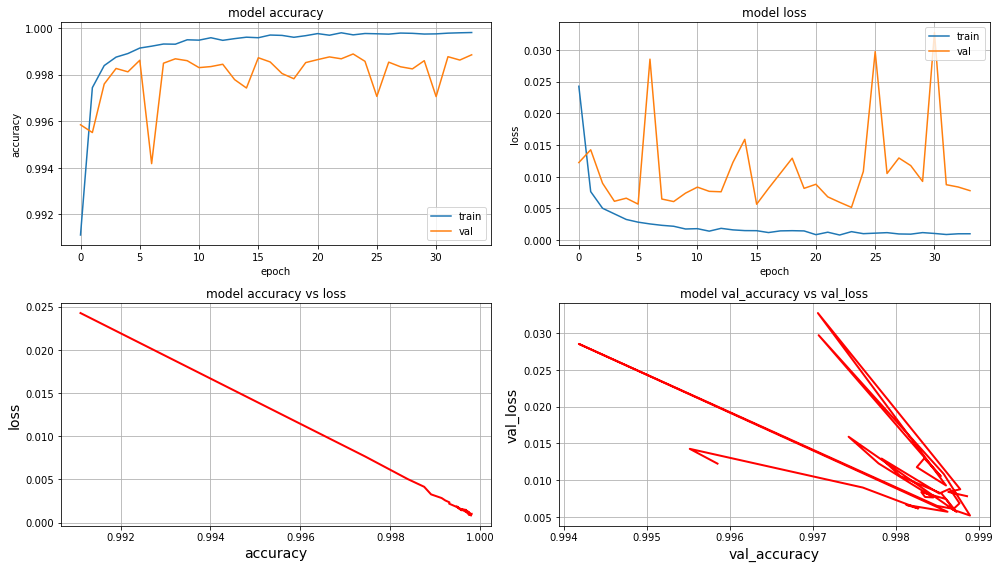

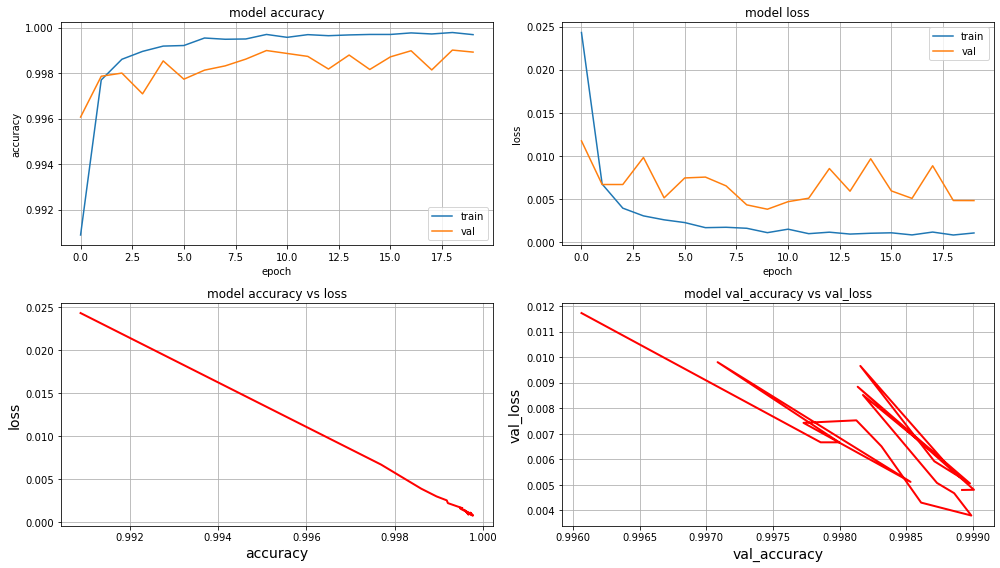

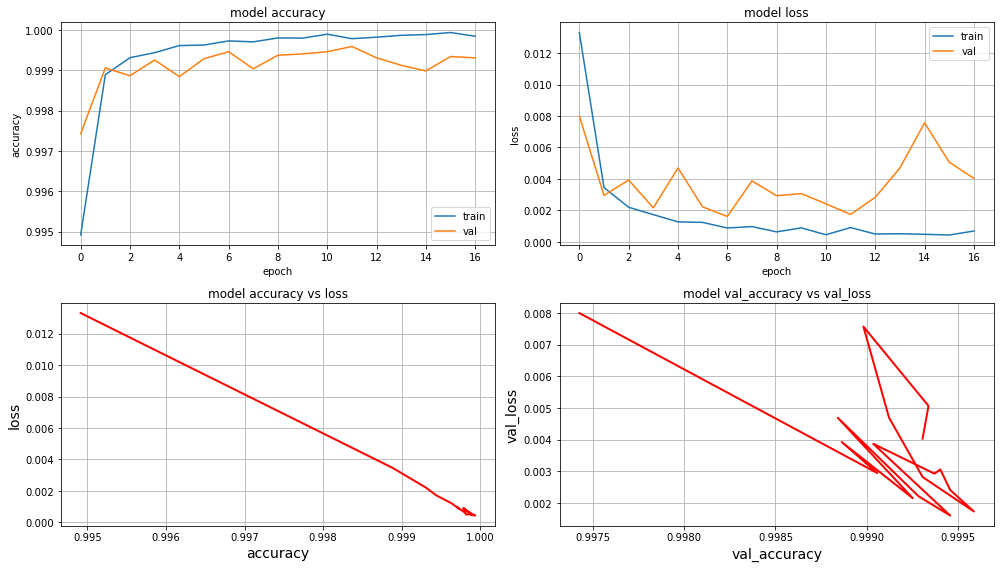

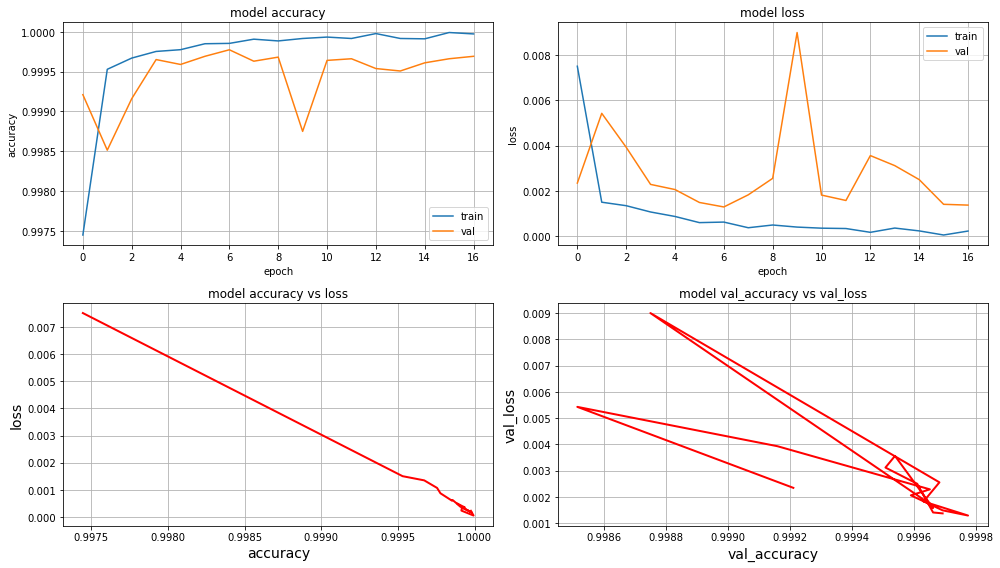

In [6]:
from audace.plotters import plot_nn_learning_curves

for fold in ds.listAttributeValues(FOLD_NAME):
    plot_nn_learning_curves(histories[fold-1], EXP_NAME, 'learning report fold ' + str(fold))

<hr style="border:1px solid gray"></hr>

### Step 4 : Display performance reports

[2020-09-09/21:29:38.653|15.4%|75.5%|2.83GB] ========== FOLD 1 ==========


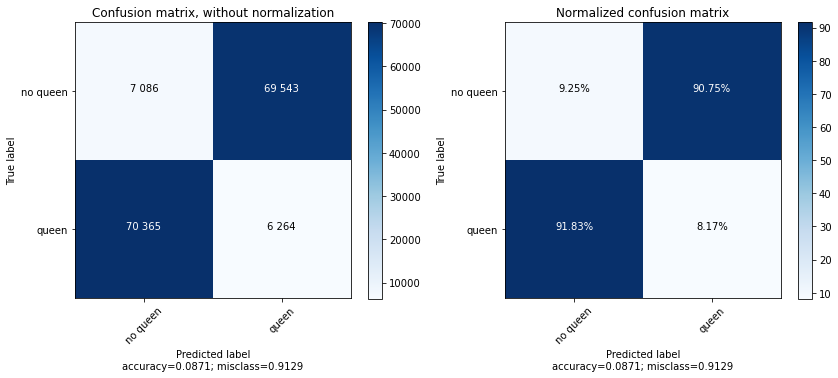

[2020-09-09/21:29:42.777|40.2%|81.1%|3.34GB] >>>>> Predict
[2020-09-09/21:29:46.765|34.7%|80.6%|3.34GB] loss: 69.08635257664993
[2020-09-09/21:29:46.766|00.0%|80.6%|3.34GB] accuracy: 0.08710801601409912
[2020-09-09/21:29:46.766|00.0%|80.6%|3.34GB] categorical_crossentropy: 69.08650970458984
[2020-09-09/21:29:51.556|30.4%|80.5%|3.34GB] ans: 0.988242049354683 / acc: 0.08059766532854426
[2020-09-09/21:29:51.557|00.0%|80.5%|3.34GB] ========== FOLD 2 ==========


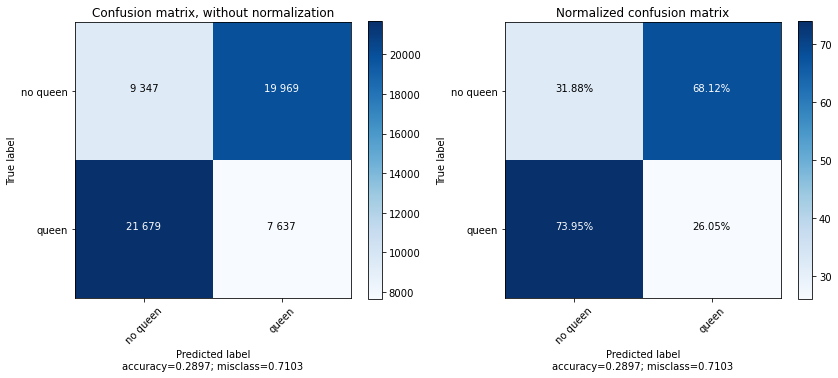

[2020-09-09/21:29:53.395|39.1%|84.1%|3.53GB] >>>>> Predict
[2020-09-09/21:29:54.885|33.9%|83.9%|3.53GB] loss: 11.908658227111815
[2020-09-09/21:29:54.885|00.0%|83.9%|3.53GB] accuracy: 0.2896711826324463
[2020-09-09/21:29:54.885|00.0%|83.9%|3.53GB] categorical_crossentropy: 11.908650398254395
[2020-09-09/21:29:56.740|30.4%|83.9%|3.53GB] ans: 0.9048812934916087 / acc: 0.26919234756384885
[2020-09-09/21:29:56.741|00.0%|83.9%|3.53GB] ========== FOLD 3 ==========


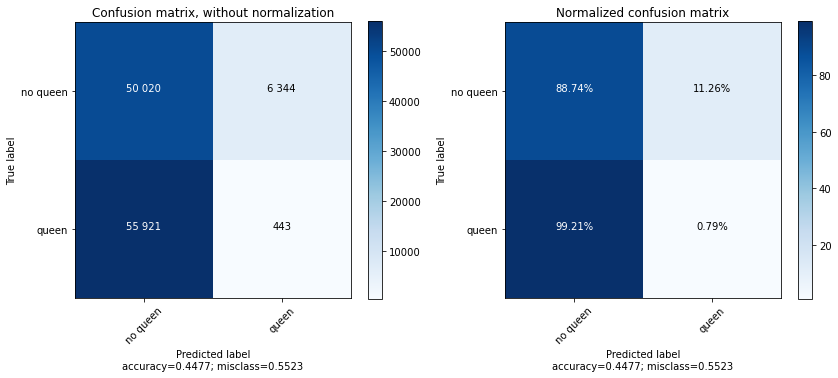

[2020-09-09/21:29:59.658|38.3%|84.6%|3.91GB] >>>>> Predict
[2020-09-09/21:30:02.638|34.4%|84.7%|3.91GB] loss: 28.72415833582618
[2020-09-09/21:30:02.638|00.0%|84.7%|3.91GB] accuracy: 0.44765275716781616
[2020-09-09/21:30:02.638|00.0%|84.7%|3.91GB] categorical_crossentropy: 28.724199295043945
[2020-09-09/21:30:06.100|29.2%|84.7%|3.91GB] ans: 0.969883258817685 / acc: 0.44551965097454566
[2020-09-09/21:30:06.101|00.0%|84.7%|3.91GB] ========== FOLD 4 ==========


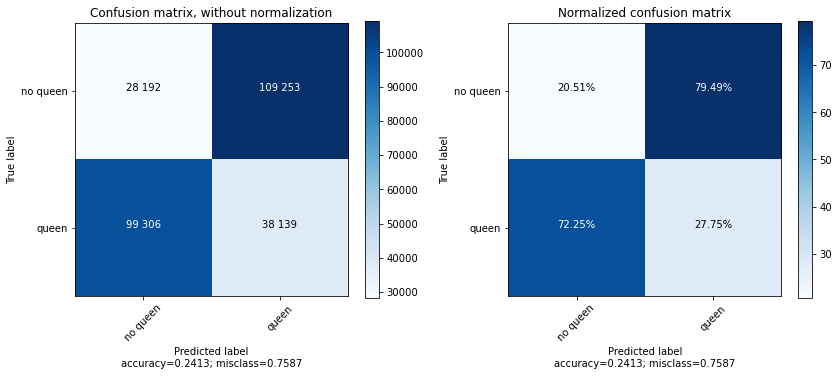

[2020-09-09/21:30:12.313|31.3%|84.6%|3.91GB] >>>>> Predict
[2020-09-09/21:30:19.866|38.7%|84.9%|3.91GB] loss: 26.476764163787067
[2020-09-09/21:30:19.867|00.0%|84.9%|3.91GB] accuracy: 0.24130015075206757
[2020-09-09/21:30:19.867|00.0%|84.9%|3.91GB] categorical_crossentropy: 26.476764678955078
[2020-09-09/21:30:28.918|33.3%|85.9%|3.91GB] ans: 0.9673578522318018 / acc: 0.2323883016129093


In [7]:
from audace.plotters import nn_full_report
from audace.metrics import i_may_be_wrong_categorical

for i, fold in enumerate(ds.listAttributeValues(FOLD_NAME)):
    iprint(F"========== FOLD {fold} ==========")
    nn_full_report(models[i], X_tests[i], y_tests[i], target_names = ['no queen', 'queen'])

    #Predict the response for test dataset
    iprint('>>>>> Predict')
    scores = models[i].evaluate(X_tests[i], y_tests[i], verbose=0)

    for j in range(len(scores)):
        iprint(F"{models[i].metrics_names[j]}: {scores[j]}")
        
        
    ans, acc = i_may_be_wrong_categorical(models[i], X_tests[i], y_tests[i], 0.9)
    iprint(F"ans: {ans} / acc: {acc}")